In [1]:
import random
from pathlib import Path

import torch
import torchvision.models as models
from torchvision import transforms
from torchinfo import summary

from load_data_functions import create_cv_datasets, create_dataloaders
from engine import load_adapted_emonet, get_loss_optimizer, create_writer, train, pretty_json, plot_loss_curves, pred_and_plot_n_images

In [2]:
# get current hyperparameter setup
batch_size = 64
loss_fn_str = "MSE"
learning_rate = 0.001
optimizer_str = "Adam"
num_epochs = 30
train_percentage = 1.0

In [3]:
# other variables relevant for training
split_path = Path("data/train_test_split")
fold_list = [split_path / f"fold_{i}" for i in range(1, 6)]
used_fold = "fold_1"
img_size = 256
model_name = "adapted_emonet"

In [4]:
# setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# load an Emonet model with a custom classifier head
model = load_adapted_emonet(device)
summary(model=model,
        input_size=(64, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

[INFO] Created a new baseline EmoNet model.


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
AdaptedEmoNet (AdaptedEmoNet)            [64, 3, 256, 256]    [64, 1]              --                   Partial
├─Conv2d (conv1)                         [64, 3, 256, 256]    [64, 64, 128, 128]   (9,472)              False
├─BatchNorm2d (bn1)                      [64, 64, 128, 128]   [64, 64, 128, 128]   (128)                False
├─ConvBlock (conv2)                      [64, 64, 128, 128]   [64, 128, 128, 128]  --                   False
│    └─BatchNorm2d (bn1)                 [64, 64, 128, 128]   [64, 64, 128, 128]   (128)                False
│    └─Conv2d (conv1)                    [64, 64, 128, 128]   [64, 64, 128, 128]   (36,864)             False
│    └─BatchNorm2d (bn2)                 [64, 64, 128, 128]   [64, 64, 128, 128]   (128)                False
│    └─Conv2d (conv2)                    [64, 64, 128, 128]   [64, 32, 128, 128]   (18,432)             False
│   

In [6]:
# get loss function and optimizer
loss_fn, optimizer = get_loss_optimizer(loss_fn_str, optimizer_str, model, learning_rate)

In [7]:
# define the transforms (standard transforms are performed, as these are not specified in Toisoul et al., 2021)
data_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
# load training and validation data (only one fold to see how training goes)
datasets = create_cv_datasets(fold_list, data_transforms, select_one=False, train_percentage=train_percentage)
train_data = datasets[used_fold]["train"]
validation_data = datasets[used_fold]["validation"]
print(f"Size of the training set: {len(train_data)}")
print(f"Size of the validation set: {len(validation_data)}")
train_loader, val_loader = create_dataloaders(train_data, validation_data, device, batch_size)

Size of the training set: 19803
Size of the validation set: 4915


In [9]:
# create a writer to track training results
writer = create_writer(f"model_selection", model_name)

[INFO] Created SummaryWriter, saving to: runs\model_selection\adapted_emonet\2024-05-26_11-00-36...


In [10]:
# track hyperparameters and other important information
info = {
        "model_name": model_name,
        "batch_size": batch_size,
        "loss_fn_str": loss_fn_str,
        "learning_rate": learning_rate,
        "augmentation": False,
        "split_path": str(split_path),
        "fold_list": [str(fold) for fold in fold_list],
        "validation_fold": used_fold,
        "img_size": img_size,
        "num_epochs": num_epochs,
        "optimizer_str": optimizer_str,
        "percentage": train_percentage
    }

writer.add_text("Miscellaneous", pretty_json(info))

In [11]:
# train the model and track performance
model.to(device)
performance = train(num_epochs=num_epochs,
                    model=model,
                    train_loader=train_loader,
                    val_loader=val_loader,
                    loss_fn=loss_fn,
                    optimizer=optimizer,
                    device=device,
                    writer=writer,
                    early_stopping=True)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0386 | train_ccc: 0.7560 | train_pcc: 0.7779 | val_loss: 0.0689 | val_ccc: 0.2583 | val_pcc: 0.3672
Epoch: 2 | train_loss: 0.0186 | train_ccc: 0.8636 | train_pcc: 0.8805 | val_loss: 0.3774 | val_ccc: 0.0760 | val_pcc: 0.3525
Epoch: 3 | train_loss: 0.0150 | train_ccc: 0.8913 | train_pcc: 0.9054 | val_loss: 0.1044 | val_ccc: 0.2188 | val_pcc: 0.3559
Epoch: 4 | train_loss: 0.0134 | train_ccc: 0.9044 | train_pcc: 0.9202 | val_loss: 0.0512 | val_ccc: 0.2431 | val_pcc: 0.3363
Epoch: 5 | train_loss: 0.0114 | train_ccc: 0.9192 | train_pcc: 0.9310 | val_loss: 0.0735 | val_ccc: 0.2366 | val_pcc: 0.3166
Epoch: 6 | train_loss: 0.0107 | train_ccc: 0.9246 | train_pcc: 0.9360 | val_loss: 0.0719 | val_ccc: 0.2437 | val_pcc: 0.3540
Epoch: 7 | train_loss: 0.0104 | train_ccc: 0.9268 | train_pcc: 0.9391 | val_loss: 0.0747 | val_ccc: 0.2293 | val_pcc: 0.3350
Epoch: 8 | train_loss: 0.0096 | train_ccc: 0.9329 | train_pcc: 0.9444 | val_loss: 0.0972 | val_ccc: 0.1914 | val_pcc: 0.3865


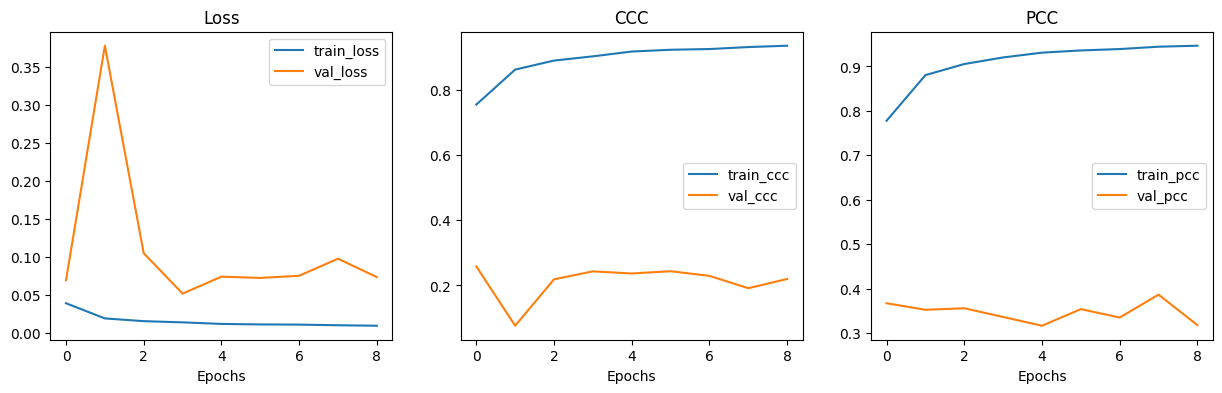

In [12]:
# plot loss curves
plot_loss_curves(performance)

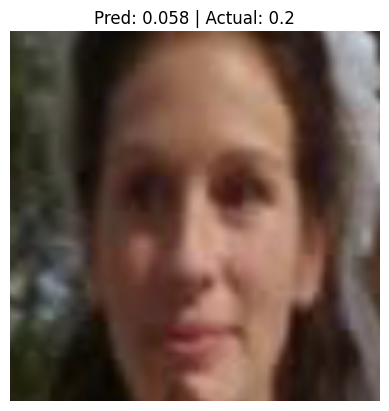

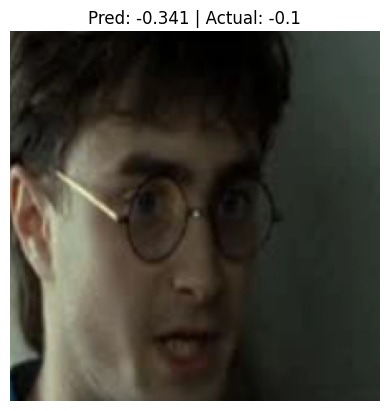

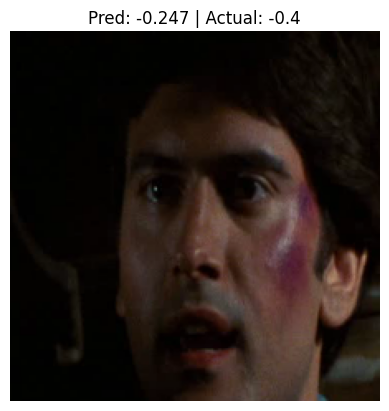

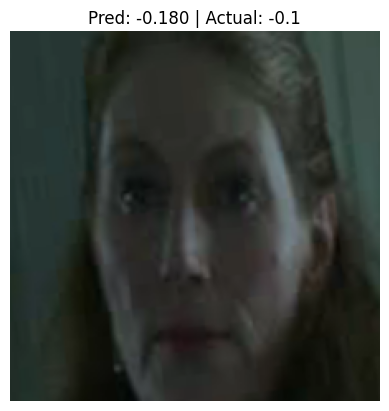

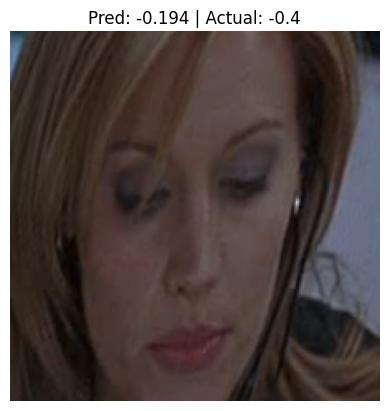

In [13]:
# make predictions
pred_and_plot_n_images(model=model, 
                       val_path = str(fold_list[0]), 
                       num_images_to_plot=5, 
                       image_size=(img_size, img_size), 
                       transform=data_transforms,
                       device=device)